# **Desafío Final**

## Data Science 

### Digital House 

#### Comisión 14

El objetivo del presente trabajo es predecir el comportamiento a corto plazo del precio de Bitcoin, tomando como base la reacción observada en el pasado del precio de dicha cryptomoneda a los posteos realizados en Twitter.

La forma en que se trabajó, consistió en agrupar tweets relacionados a Bitcoin en función a la hora y el día en que fueron publicados y clasificarlos según el comportamiento del valor de Bitcoin una determinada cantidad de horas después de la emisión de los tweets (esta ventana se probó con 2, 6, 12 y 24hs).

Para el el presente análisis, se obtuvieron dos bases de datos de Kaggle.com.

Una Base de Datos con el precio por minuto de Bitcoin (https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution), y otra con Tweets relacionados con Bitcoin (https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets)

### Pre-processing

In [6]:
import pandas as pd
import datetime as dt
import numpy as np
#from google.colab import drive
#drive.mount('/content/gdrive/')
root_path_Colab = 'gdrive/MyDrive/Colab Notebooks/' 
root_path = str(r'C:\Users\Mariano desktop\OneDrive\Desktop\Curso Data Science Digital House\Trabajo Final/')
root_path

'C:\\Users\\Mariano desktop\\OneDrive\\Desktop\\Curso Data Science Digital House\\Trabajo Final/'

Importamos el Dataset con información relacionada al valor de Bitcoin

In [10]:
data_btcusd=pd.read_csv(root_path+'Data/btcusd.csv')

data_btcusd.head()

,time,open,close,high,low,volume
0,1364774820000,93.25,93.30,93.30,93.25,93.300000
1,1364774880000,100.00,100.00,100.00,100.00,93.300000
2,1364774940000,93.30,93.30,93.30,93.30,33.676862
3,1364775060000,93.35,93.47,93.47,93.35,20.000000
4,1364775120000,93.47,93.47,93.47,93.47,2.021627


Convertimos el formato de la fecha

In [11]:
data_btcusd['time']=data_btcusd['time'].apply(lambda x: dt.datetime.fromtimestamp(x/1000)) #.strftime('%Y-%m-%d %H:%M:%S'))
data_btcusd.head()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


,time,open,close,high,low,volume
0,2013-03-31 21:07:00,93.25,93.30,93.30,93.25,93.300000
1,2013-03-31 21:08:00,100.00,100.00,100.00,100.00,93.300000
2,2013-03-31 21:09:00,93.30,93.30,93.30,93.30,33.676862
3,2013-03-31 21:11:00,93.35,93.47,93.47,93.35,20.000000
4,2013-03-31 21:12:00,93.47,93.47,93.47,93.47,2.021627


Analizamos las características del dataset

In [12]:
data_btcusd.dtypes

time      datetime64[ns]
open             float64
close            float64
high             float64
low              float64
volume           float64
dtype: object

In [13]:
data_btcusd.shape

(3750538, 6)

In [14]:
data_btcusd.time.tail()

3750533   2022-02-26 07:48:00
3750534   2022-02-26 07:49:00
3750535   2022-02-26 07:50:00
3750536   2022-02-26 07:51:00
3750537   2022-02-26 07:52:00
Name: time, dtype: datetime64[ns]

Importamos el Dataset de los Tweets relacionados con Bitcoin

In [15]:
data_tweets=pd.read_csv(root_path+'Data/Bitcoin_tweets.csv');

data_tweets.head(3)

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False


Nos quedamos con las features que consideramos importantes para nuestro análisis

In [16]:
data_tweets=data_tweets.loc[:,['user_followers', 'date', 'text', 'is_retweet']]
data_tweets.head()

,user_followers,date,text,is_retweet
0,8534.0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,False
1,6769.0,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...",False
2,128.0,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",False
3,625.0,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,False
4,1249.0,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,False


Analizamos las características del dataset

In [17]:
data_tweets.shape

(2434037, 4)

Eliminamos los campos que tienen datos incorrectos en el Feature "date" y los nulos

In [18]:
data_tweets.date.sort_values(ascending=False).head(15)

1393938    ['cryptotrading', 'crypto', 'tradingbots', 'bi...
137068     ['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum...
693194                                               ['btc']
697397                                               ['btc']
1611481                                          ['bitcoin']
1067665    ['YieldFarming', 'Airdrop', 'PancakeSwap', 'Gi...
180575     ['YieldFarming', 'Airdrop', 'Binance', 'Bitcoi...
1513850    ['PW', 'pythonwealth', 'Presale', 'token', 'ic...
64943                              ['ETH', 'BTC', 'Bitcoin']
1347699                                          ['Bitcoin']
1811149    ['Airdrop', 'Airdrops', 'Airdropinspector', 'B...
2354296                                  2022-03-10 23:59:55
2354297                                  2022-03-10 23:59:52
2354298                                  2022-03-10 23:59:41
2354299                                  2022-03-10 23:59:32
Name: date, dtype: object

In [19]:
lista_drop = data_tweets.date.sort_values(ascending=False).index[:11]
lista_drop

Int64Index([1393938,  137068,  693194,  697397, 1611481, 1067665,  180575,
            1513850,   64943, 1347699, 1811149],
           dtype='int64')

In [20]:
data_tweets.drop(lista_drop, inplace=True, axis=0)

In [21]:
data_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434026 entries, 0 to 2434036
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_followers  float64
 1   date            object 
 2   text            object 
 3   is_retweet      object 
dtypes: float64(1), object(3)
memory usage: 92.9+ MB


In [22]:
data_tweets.isna().sum()

user_followers    101
date              101
text              101
is_retweet        370
dtype: int64

In [23]:
data_tweets.dropna(inplace=True)

Modificamos el formato de la fecha

In [24]:
date_series_str=data_tweets.date
# lista_errores=['ETH', 'BTC', 'Bitcoin']
# date_series_str.drop(lista_errores,axis=0)
date=[dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in date_series_str]

In [25]:
data_tweets['date'] = date
data_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433656 entries, 0 to 2434036
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_followers  float64       
 1   date            datetime64[ns]
 2   text            object        
 3   is_retweet      object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 92.8+ MB


In [26]:
data_tweets.head()

,user_followers,date,text,is_retweet
0,8534.0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,False
1,6769.0,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...",False
2,128.0,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",False
3,625.0,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,False
4,1249.0,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,False


Verificamos que el Dataset no contiene retweets y dropeamos esa feature

In [27]:
data_tweets.is_retweet.unique()

array([False], dtype=object)

In [28]:
data_tweets.drop('is_retweet', axis=1, inplace=True)
data_tweets.head()

,user_followers,date,text
0,8534.0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,6769.0,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
2,128.0,2021-02-10 23:54:48,"Guys evening, I have read this article about B..."
3,625.0,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
4,1249.0,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...


Observanos las fechas sobre las cuales el dataset obtenido tiene información

In [29]:
data_tweets.date[0:1500:100]

0      2021-02-10 23:59:04
100    2021-02-10 23:07:09
200    2021-02-10 22:25:24
300    2021-02-10 21:46:51
400    2021-02-10 21:00:02
500    2021-02-10 20:15:18
600    2021-02-10 19:41:15
700    2021-02-10 18:57:27
800    2021-02-10 18:29:25
900    2021-02-10 17:59:23
1000   2021-02-10 17:26:28
1100   2021-02-10 16:45:01
1200   2021-02-10 16:17:37
1300   2021-02-10 15:52:20
1400   2021-02-10 15:27:59
Name: date, dtype: datetime64[ns]

In [30]:
data_tweets_ordered=data_tweets.sort_values(by='date')

In [31]:
dif_date = data_tweets_ordered.date.shift(-1)-data_tweets_ordered.date

In [32]:
dif_date[dif_date>'0 days 01:00:00'].sum()

Timedelta('300 days 23:03:16')

In [33]:
data_tweets_ordered.date.iloc[-1]-data_tweets_ordered.date.iloc[0]

Timedelta('398 days 13:07:51')

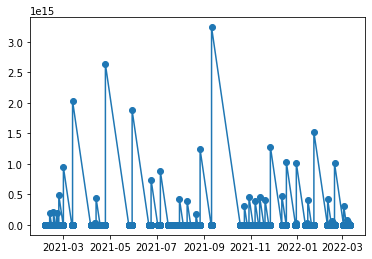

In [34]:
# Import Library

import matplotlib.pyplot as plt

# Plot

plt.plot(data_tweets_ordered['date'][:-3],dif_date[:-3],marker='o')

Eliminamos los tweets de usuarios con menos de 150 seguidores, por considerarlos poco relevantes y posibles bots 

In [35]:
min_followers_mask = data_tweets.user_followers >= 150 #definir el número mínimo

data_tweets_2 = data_tweets.loc[min_followers_mask,:]
data_tweets_2.head()

,user_followers,date,text
0,8534.0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...
1,6769.0,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""..."
3,625.0,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...
4,1249.0,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...
5,742.0,2021-02-10 23:53:30,💹 Trade #Crypto on #Binance \n\n📌 Enjoy #Cashb...


In [36]:
data_tweets_2.shape

(1341958, 3)

### Analizamos las fechas de ambos datasets para que coincidan

Ordenamos el dataset de tweets por fecha

In [37]:
data_tweets_3 = data_tweets_2.sort_values(by='date')
data_tweets_3.reset_index(inplace=True, drop=True)
data_tweets_3

,user_followers,date,text
0,301.0,2021-02-05 10:52:04,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...
1,301.0,2021-02-05 10:52:04,📖 Weekend Read 📖\n\nKeen to learn about #cryp...
2,301.0,2021-02-05 10:52:06,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...
3,301.0,2021-02-05 10:52:07,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe..."
4,163.0,2021-02-05 10:57:05,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...
...,...,...,...
1341953,327.0,2022-03-10 23:59:03,@CryptoNostra $FWT @FreewayFi and their superc...
1341954,286.0,2022-03-10 23:59:05,4 hour top movers report #blockchain #crypto #...
1341955,2579.0,2022-03-10 23:59:09,Top 5 #crypto prices with 24h change:\n\n#BTC ...
1341956,9931.0,2022-03-10 23:59:11,It’s painful seeing my TINY #BTC buys in 2016\...


Vemos rango de fechas de dataset de tweets

In [38]:
tiempo_inicio_tweets = data_tweets_3.loc[0,'date']
print('Tiempo inicio tweets:',tiempo_inicio_tweets)
tiempo_final_tweets = data_tweets_3.iloc[-1,1]
print('Tiempo final tweets:',tiempo_final_tweets)

Tiempo inicio tweets: 2021-02-05 10:52:04
Tiempo final tweets: 2022-03-10 23:59:31


Vemos rango de fechas de dataset de Bitcoin

In [39]:
tiempo_inicio_btc = data_btcusd.loc[0,'time']
print('Tiempo inicio btc:',tiempo_inicio_btc)
tiempo_final_btc = data_btcusd.iloc[-1,0]
print('Tiempo final btc:',tiempo_final_btc)

Tiempo inicio btc: 2013-03-31 21:07:00
Tiempo final btc: 2022-02-26 07:52:00


Nos quedamos con el rango de fechas en que ambos coinciden

In [40]:
if tiempo_inicio_tweets > tiempo_inicio_btc:
    tiempo_data_inicio = tiempo_inicio_tweets
else:
    tiempo_data_inicio = tiempo_inicio_btc

In [41]:
tiempo_data_inicio

Timestamp('2021-02-05 10:52:04')

In [42]:
if tiempo_final_tweets < tiempo_final_btc:
    tiempo_data_final = tiempo_final_tweets
else:
    tiempo_data_final = tiempo_final_btc

In [43]:
tiempo_data_final

Timestamp('2022-02-26 07:52:00')

In [44]:
data_btc_mask = (data_btcusd.time >= tiempo_data_inicio) & (data_btcusd.time <= tiempo_data_final)
data_tweet_mask = (data_tweets_3.date >= tiempo_data_inicio) & (data_tweets_3.date <= tiempo_data_final)

Dataset con valores de Bitcoin para la fecha coincidente

In [45]:
data_btcusd = data_btcusd.loc[data_btc_mask,:]
data_btcusd.head()

,time,open,close,high,low,volume
3198003,2021-02-05 10:53:00,38236.000000,38226.721195,38243.000000,38175.000000,4.782804
3198004,2021-02-05 10:54:00,38231.000000,38336.000000,38336.047343,38211.064618,37.722672
3198005,2021-02-05 10:55:00,38322.828016,38317.138180,38366.000000,38287.977064,10.637205
3198006,2021-02-05 10:56:00,38331.000000,38318.000000,38331.000000,38268.000000,9.602213
3198007,2021-02-05 10:57:00,38316.819231,38304.000000,38332.000000,38303.000000,11.947110


In [46]:
data_btcusd.shape

(552535, 6)

Dataset con tweets de Bitcoin para la fecha coincidente

In [47]:
data_tweets_3 = data_tweets_3.loc[data_tweet_mask,:]
data_tweets_3.head()

,user_followers,date,text
0,301.0,2021-02-05 10:52:04,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...
1,301.0,2021-02-05 10:52:04,📖 Weekend Read 📖\n\nKeen to learn about #cryp...
2,301.0,2021-02-05 10:52:06,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...
3,301.0,2021-02-05 10:52:07,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe..."
4,163.0,2021-02-05 10:57:05,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...


In [48]:
data_tweets_3.shape

(1290445, 3)

In [49]:
data_btcusd.index = data_btcusd.time

Nos quedamos con los vlaores de Bitcoin de los cierres de cada hora (para todo el período analizado)

In [50]:
data_btc_resample = pd.DataFrame(data_btcusd.open.resample('H').first())
data_btc_resample.head()

,open
time,
2021-02-05 10:00:00,38236.0
2021-02-05 11:00:00,38354.0
2021-02-05 12:00:00,38126.0
2021-02-05 13:00:00,37962.0
2021-02-05 14:00:00,37811.0


In [51]:
data_btc_resample['close'] = data_btcusd.close.resample('H').last()
data_btc_resample.head()

,open,close
time,,
2021-02-05 10:00:00,38236.0,38355.00000
2021-02-05 11:00:00,38354.0,38128.00000
2021-02-05 12:00:00,38126.0,37947.00000
2021-02-05 13:00:00,37962.0,37810.93318
2021-02-05 14:00:00,37811.0,37872.00000


In [52]:
data_btc_resample['high'] = data_btcusd.high.resample('H').max()
data_btc_resample.head()

,open,close,high
time,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0
2021-02-05 11:00:00,38354.0,38128.00000,38366.0
2021-02-05 12:00:00,38126.0,37947.00000,38309.0
2021-02-05 13:00:00,37962.0,37810.93318,38183.0
2021-02-05 14:00:00,37811.0,37872.00000,37941.0


In [53]:
data_btc_resample['low'] = data_btcusd.low.resample('H').min()
data_btc_resample.head()

,open,close,high,low
time,,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000
2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000
2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556
2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000
2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000


In [54]:
data_btc_resample['volume'] = data_btcusd.volume.resample('H').sum()
data_btc_resample.head() 

,open,close,high,low,volume
time,,,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000,78.510053
2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000,157.987029
2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556,197.929364
2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000,414.629575
2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000,90.369899


In [55]:
data_btc_resample.describe()

,open,close,high,low,volume
count,9257.000000,9257.000000,9257.000000,9257.000000,9262.000000
mean,47612.783557,47613.085106,47878.873927,47330.043473,326.231542
std,9104.971332,9104.860057,9120.726412,9085.465610,489.720237
min,29446.000000,29447.000000,29718.000000,29247.000000,0.000000
25%,39975.000000,39975.000000,40221.000000,39681.000000,102.685142
50%,47484.000000,47484.000000,47739.000000,47200.000000,188.982775
75%,55763.000000,55768.234837,56130.000000,55368.000000,359.018477
max,68601.000000,68601.000000,68958.000000,68450.000000,11111.599499


Para generar el campo en el que observaremos si el Bitcoin subió o bajó de valor respecto de la hora anterior, desplazamos el precio de cierre y luego calculamos la diferencia con el de la hora de cada fila 

In [56]:
n = 1
close_hora_siguiente = data_btc_resample.close.shift(-n) 
close_hora_siguiente

time
2021-02-05 10:00:00    38128.000000
2021-02-05 11:00:00    37947.000000
2021-02-05 12:00:00    37810.933180
2021-02-05 13:00:00    37872.000000
2021-02-05 14:00:00    37371.000000
                           ...     
2022-02-26 03:00:00    39230.000000
2022-02-26 04:00:00    38795.739269
2022-02-26 05:00:00    38836.000000
2022-02-26 06:00:00    39069.000000
2022-02-26 07:00:00             NaN
Freq: H, Name: close, Length: 9262, dtype: float64

In [57]:
data_btc_resample['evolucion_close'] = data_btc_resample.close - close_hora_siguiente
data_btc_resample.head() 

,open,close,high,low,volume,evolucion_close
time,,,,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000,78.510053,227.00000
2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000,157.987029,181.00000
2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556,197.929364,136.06682
2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000,414.629575,-61.06682
2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000,90.369899,501.00000


In [58]:
data_btc_resample.describe()

,open,close,high,low,volume,evolucion_close
count,9257.000000,9257.000000,9257.000000,9257.000000,9262.000000,9254.000000
mean,47612.783557,47613.085106,47878.873927,47330.043473,326.231542,-0.079317
std,9104.971332,9104.860057,9120.726412,9085.465610,489.720237,388.089231
min,29446.000000,29447.000000,29718.000000,29247.000000,0.000000,-3878.000000
25%,39975.000000,39975.000000,40221.000000,39681.000000,102.685142,-183.000000
50%,47484.000000,47484.000000,47739.000000,47200.000000,188.982775,-2.914875
75%,55763.000000,55768.234837,56130.000000,55368.000000,359.018477,181.000000
max,68601.000000,68601.000000,68958.000000,68450.000000,11111.599499,4251.000000


In [59]:
data_btc_resample['label'] = (data_btc_resample.evolucion_close > 0).astype(int)
data_btc_resample.head()

,open,close,high,low,volume,evolucion_close,label
time,,,,,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000,78.510053,227.00000,1
2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000,157.987029,181.00000,1
2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556,197.929364,136.06682,1
2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000,414.629575,-61.06682,0
2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000,90.369899,501.00000,1


Redondeamos la hora de publicación de cada tweet para poder vincularlo con el label generado anteriormente en el dataset con los valores de Bitcoin

In [ ]:
#data_tweets_3.to_csv(root_path+'Data/data_tweets_3.csv')

In [61]:
data_tweets_3.date.shift(-1)

0         2021-02-05 10:52:04
1         2021-02-05 10:52:06
2         2021-02-05 10:52:07
3         2021-02-05 10:57:05
4         2021-02-05 10:58:03
                  ...        
1290440   2022-02-18 23:59:27
1290441   2022-02-18 23:59:30
1290442   2022-02-18 23:59:30
1290443   2022-02-18 23:59:34
1290444                   NaT
Name: date, Length: 1290445, dtype: datetime64[ns]

In [62]:
date_redondeado = [time.floor('H') for time in data_tweets_3.date]
date_redondeado

[Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 10:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-05 11:00:00'),
 Timestamp('2021-02-

In [63]:
data_tweets_3['date'] = date_redondeado
data_tweets_3.head()

C:\Users\MARIAN~1\AppData\Local\Temp/ipykernel_27432/971523947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweets_3['date'] = date_redondeado


,user_followers,date,text
0,301.0,2021-02-05 10:00:00,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...
1,301.0,2021-02-05 10:00:00,📖 Weekend Read 📖\n\nKeen to learn about #cryp...
2,301.0,2021-02-05 10:00:00,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...
3,301.0,2021-02-05 10:00:00,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe..."
4,163.0,2021-02-05 10:00:00,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...


In [64]:
data_tweets_3.index = data_tweets_3.date
data_tweets_3.drop('date', inplace=True, axis=1)
data_tweets_3.head()

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user_followers,text
date,,
2021-02-05 10:00:00,301.0,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...
2021-02-05 10:00:00,301.0,📖 Weekend Read 📖\n\nKeen to learn about #cryp...
2021-02-05 10:00:00,301.0,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...
2021-02-05 10:00:00,301.0,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe..."
2021-02-05 10:00:00,163.0,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...


In [65]:
data_tweets_3.shape

(1290445, 2)

In [66]:
#data_tweets_3.drop_duplicates(['text'], keep='first') # dropear duplicados
#data_tweets_3.head()

In [67]:
data_tweets_3.shape

(1290445, 2)

In [ ]:
#data_tweets_3.to_csv(root_path+'Data/data_tweets.csv')

In [ ]:
#data_btc_resample.to_csv(root_path+'Data/data_btcusd.csv')

### Determinación de ventana y Text Mining

In [69]:
data_btcusd=pd.read_csv(root_path+'Data/data_btcusd.csv')

data_btcusd.head()

,time,open,close,high,low,volume,evolucion_close,label
0,2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000,78.510053,227.00000,1
1,2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000,157.987029,181.00000,1
2,2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556,197.929364,136.06682,1
3,2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000,414.629575,-61.06682,0
4,2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000,90.369899,501.00000,1


In [70]:
data_btcusd.set_index('time', drop=True, inplace=True)
data_btcusd.head()

,open,close,high,low,volume,evolucion_close,label
time,,,,,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000,78.510053,227.00000,1
2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000,157.987029,181.00000,1
2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556,197.929364,136.06682,1
2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000,414.629575,-61.06682,0
2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000,90.369899,501.00000,1


In [71]:
data_btcusd.shape

(9262, 7)

In [72]:
data_tweets=pd.read_csv(root_path+'Data/data_tweets.csv')

data_tweets.head()

,date,user_followers,text
0,2021-02-05 10:00:00,301.0,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...
1,2021-02-05 10:00:00,301.0,📖 Weekend Read 📖\n\nKeen to learn about #cryp...
2,2021-02-05 10:00:00,301.0,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...
3,2021-02-05 10:00:00,301.0,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe..."
4,2021-02-05 10:00:00,163.0,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...


In [73]:
data_tweets.set_index('date', drop=True, inplace=True)
data_tweets.head()

,user_followers,text
date,,
2021-02-05 10:00:00,301.0,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...
2021-02-05 10:00:00,301.0,📖 Weekend Read 📖\n\nKeen to learn about #cryp...
2021-02-05 10:00:00,301.0,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...
2021-02-05 10:00:00,301.0,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe..."
2021-02-05 10:00:00,163.0,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...


In [74]:
# ver Nans del final
# generar n para ventana de tiempo entre tweet y comportamiento de mercado

Desplazamos el label generado en el dataset con valores de Bitcoin para poder hacer un join con el dataset de tweets y vincular los tweets con el comportamiento de la cryptomoneda en un plazo determinado de horas

In [75]:
n_label = 24
ventana_label = data_btcusd.label.shift(-n_label) #se puede cambiar n
ventana_label

time
2021-02-05 10:00:00    0.0
2021-02-05 11:00:00    0.0
2021-02-05 12:00:00    1.0
2021-02-05 13:00:00    1.0
2021-02-05 14:00:00    0.0
                      ... 
2022-02-26 03:00:00    NaN
2022-02-26 04:00:00    NaN
2022-02-26 05:00:00    NaN
2022-02-26 06:00:00    NaN
2022-02-26 07:00:00    NaN
Name: label, Length: 9262, dtype: float64

Llamamos 'Target' al label luego de haberlo desfazado n cantidad de horas

In [76]:
data_btcusd['target'] = ventana_label
data_btcusd.head()

,open,close,high,low,volume,evolucion_close,label,target
time,,,,,,,,
2021-02-05 10:00:00,38236.0,38355.00000,38366.0,38175.000000,78.510053,227.00000,1,0.0
2021-02-05 11:00:00,38354.0,38128.00000,38366.0,38022.000000,157.987029,181.00000,1,0.0
2021-02-05 12:00:00,38126.0,37947.00000,38309.0,37918.654556,197.929364,136.06682,1,1.0
2021-02-05 13:00:00,37962.0,37810.93318,38183.0,37701.000000,414.629575,-61.06682,0,1.0
2021-02-05 14:00:00,37811.0,37872.00000,37941.0,37756.000000,90.369899,501.00000,1,0.0


In [77]:
data_btcusd.dropna(axis=0, inplace=True)

In [78]:
data_btcusd['target'].isna().sum()

0

Hacemos el join de la variable target con el dataset de tweets

In [79]:
data = data_tweets.join(data_btcusd[['volume', 'target']], how='left')
data

,user_followers,text,volume,target
2021-02-05 10:00:00,301.0,2⃣ Debunking 9 #Bitcoin Myths by @Patrick_Lo...,78.510053,0.0
2021-02-05 10:00:00,301.0,📖 Weekend Read 📖\n\nKeen to learn about #cryp...,78.510053,0.0
2021-02-05 10:00:00,301.0,4⃣ 🎙️ Bloomberg LP #CryptoOutlook 2021 with @...,78.510053,0.0
2021-02-05 10:00:00,301.0,"5⃣ #Blockchain 50 2021 by @DelRayMan, @Forbe...",78.510053,0.0
2021-02-05 10:00:00,163.0,#Amazing 😍\n#Monopoly #Crypto #cryptocurrency ...,78.510053,0.0
...,...,...,...,...
2022-01-13 15:00:00,221770.0,Ugly LTF rejection on #Bitcoin hopefully we ar...,80.718062,0.0
2022-01-13 15:00:00,8241.0,Polynesian nation of #Tonga announced its plan...,80.718062,0.0
2022-01-13 15:00:00,4609.0,#Bitcoin now = 130M users\nInternet in 1997 = ...,80.718062,0.0
2022-01-13 15:00:00,14520.0,#Bitcoin Miner Rhodium’s Planned IPO Values It...,80.718062,0.0


In [80]:
# convertimos todo a minúscula
data.text = [x.lower() for x in data.text]

In [81]:
data.head()

,user_followers,text,volume,target
2021-02-05 10:00:00,301.0,2⃣ debunking 9 #bitcoin myths by @patrick_lo...,78.510053,0.0
2021-02-05 10:00:00,301.0,📖 weekend read 📖\n\nkeen to learn about #cryp...,78.510053,0.0
2021-02-05 10:00:00,301.0,4⃣ 🎙️ bloomberg lp #cryptooutlook 2021 with @...,78.510053,0.0
2021-02-05 10:00:00,301.0,"5⃣ #blockchain 50 2021 by @delrayman, @forbe...",78.510053,0.0
2021-02-05 10:00:00,163.0,#amazing 😍\n#monopoly #crypto #cryptocurrency ...,78.510053,0.0


In [82]:
# eliminamos menciones, hashtags, etc
import re
import string

mencion = re.compile("@\S+")
links = re.compile("https*\S+")
hashtags = re.compile("#\S+")
apostrofes = re.compile("\'\w+")
puntuaciones = re.compile('[%s]' % re.escape(string.punctuation))
numeros = re.compile(r'\w*\d+\w*')
espacios = re.compile('\s{2,}')#(' +')
html = re.compile('<.*?>') 
alfanumericos = re.compile("[^a-z0-9]")
aa = re.compile("aa\S+")
def eliminar(x):
    clean_mencion = re.sub(mencion, " ", x)
    clean_links = re.sub(links, " ", clean_mencion)
    clean_hashtags = re.sub(hashtags, " ", clean_links)
    clean_apostrofes = re.sub(apostrofes, '', clean_hashtags)
    clean_puntuaciones = re.sub(puntuaciones, '', clean_apostrofes)
    clean_numeros = re.sub(numeros, '', clean_puntuaciones)
    clean_text = re.sub(html, '', clean_numeros)
    clean_alfanumericos = re.sub(alfanumericos," ", clean_text)
    clean_aa = re.sub(aa," ", clean_alfanumericos)
    clean_espacios = re.sub(espacios,' ', clean_aa)
    return clean_espacios


In [83]:
limpieza_2 = [eliminar(x) for x in data.text]

In [84]:
for i in range(10):
  print(f"Tweet original: \n {data.text[i]}",)
  print(f"\nTweet cleaned: \n {limpieza_2[i]}",)


Tweet original: 
 2⃣   debunking 9 #bitcoin myths by @patrick_lowry_  ⬇️  

#cryptocurrency #bitcoin #crypto #blockchain #btc… https://t.co/2cm83fub2n

Tweet cleaned: 
  debunking myths by 
Tweet original: 
 📖  weekend read 📖

keen to learn about #crypto assets? check out our reading list! 
1⃣   2021 cryptomarket outlook… https://t.co/opiev94qzl

Tweet cleaned: 
  weekend read keen to learn about assets check out our reading list cryptomarket outlook 
Tweet original: 
 4⃣  🎙️ bloomberg lp #cryptooutlook 2021 with @mikemcglone11 ⬇️

#cryptocurrency #bitcoin #crypto #blockchain #btc… https://t.co/gc3vngap6v

Tweet cleaned: 
  bloomberg lp with 
Tweet original: 
 5⃣   #blockchain 50 2021 by @delrayman, @forbes , @forbescrypto  ⬇️

#cryptocurrency #bitcoin #crypto #blockchain… https://t.co/l3xj7j49fx

Tweet cleaned: 
  by 
Tweet original: 
 #amazing 😍
#monopoly #crypto #cryptocurrency #cryptocurrencies #cryptonews #cryptotrading #ripple #xrp… https://t.co/4dqtzsemup

Tweet cleaned: 
  
Twe

In [85]:
data.text = limpieza_2

In [86]:
data.head()

,user_followers,text,volume,target
2021-02-05 10:00:00,301.0,debunking myths by,78.510053,0.0
2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,78.510053,0.0
2021-02-05 10:00:00,301.0,bloomberg lp with,78.510053,0.0
2021-02-05 10:00:00,301.0,by,78.510053,0.0
2021-02-05 10:00:00,163.0,,78.510053,0.0


Para facilitar el procesamiento, exportamos el dataset generado con cada una de las ventanas de tiempo.

In [87]:
#data.to_csv(root_path+'Data/data_24h_prep.csv')

### Modelling Vectorizer

In [94]:
pip install xgboost

^C
Note: you may need to restart the kernel to use updated packages.


In [95]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve,auc,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [96]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score

import nltk
nltk.download('punkt')   
nltk.download('stopwords')
nltk.download('wordnet')   
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
#from google.colab import drive

[nltk_data] Downloading package punkt to C:\Users\Mariano
[nltk_data]     desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Mariano
[nltk_data]     desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Mariano
[nltk_data]     desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#root_path = 'gdrive/MyDrive/Colab Notebooks/'  

Mounted at /content/gdrive/


In [100]:
data_12 = pd.read_csv(root_path+'Data/data_24h_prep.csv')
#largo = data.shape[0]
data.head()

,user_followers,text,volume,target
2021-02-05 10:00:00,301.0,debunking myths by,78.510053,0.0
2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,78.510053,0.0
2021-02-05 10:00:00,301.0,bloomberg lp with,78.510053,0.0
2021-02-05 10:00:00,301.0,by,78.510053,0.0
2021-02-05 10:00:00,163.0,,78.510053,0.0


In [102]:
columnas = ['Fecha_hora', 'user_followers', 'text', 'volume', 'target']
data_12.columns = columnas
data_12.head()

,Fecha_hora,user_followers,text,volume,target
0,2021-02-05 10:00:00,301.0,debunking myths by,78.510053,0.0
1,2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,78.510053,0.0
2,2021-02-05 10:00:00,301.0,bloomberg lp with,78.510053,0.0
3,2021-02-05 10:00:00,301.0,by,78.510053,0.0
4,2021-02-05 10:00:00,163.0,,78.510053,0.0


In [111]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import numpy as np
stopwords_en=stopwords.words('english');
palabras_a_sacar = ['btc', 'bitcoin', 'crypto', 'price', 'amp', 'get', 'market', 'time', 'one', 'see', 'us', 'eth', 'project', 'new', 'usd']
stopwords_en.extend(palabras_a_sacar)

vectorizer=CountVectorizer(stop_words=stopwords_en);

clases=['Bear', 'Bull'];

for clase in range(0,2):
    X=vectorizer.fit_transform(data_12[data_12['target']==clase]['text']);
    counts=X.sum(axis=0);
    counts=np.array(counts);
    
    indices=np.argsort(counts);
    valores=np.sort(counts);
    indices=indices[0][::-1];
    valores=valores[0][::-1];
    terms=np.array(vectorizer.get_feature_names());

    print('\n Clase ',clases[clase-1])
    print(terms[indices[:20]])


 Clase  Bull
['buy' 'last' 'like' 'good' 'day' 'join' 'great' 'today' 'trading' 'free'
 'top' 'money' 'current' 'high' 'bullish' 'long' 'people' 'future' 'low'
 'going']

 Clase  Bear
['buy' 'last' 'like' 'good' 'day' 'trading' 'great' 'today' 'free' 'join'
 'top' 'current' 'money' 'long' 'high' 'bullish' 'people' 'future' 'next'
 'low']


In [106]:
# Train Test Split
train,test=train_test_split(data_12,stratify=data_12['target'],random_state=3);

vectorizer=TfidfVectorizer();
X_train=vectorizer.fit_transform(train['text']);
y_train=train['target'];

X_test=vectorizer.transform(test['text']);
y_test=test['target'];

In [107]:
# Naive Bayes Multinomial
nbc=MultinomialNB();

nbc.fit(X_train,y_train);
y_pred=nbc.predict(X_test);

print('Accuracy:',accuracy_score(y_test,y_pred))

Accuracy: 0.5356939130434782


In [108]:
vectorizer=TfidfVectorizer();

X=vectorizer.fit_transform(data_12['text']);
y=data_12['target'];

skf=StratifiedKFold(n_splits=3,random_state=3,shuffle=True);

params={'alpha':np.arange(0.01,1,0.05)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=3);
GS_CV.fit(X,y);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   25.3s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:   31.5s finished


best score: 0.5354478262805827
best params: {'alpha': 0.91}


In [1]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve,auc,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [112]:
# Pipeline + Grid Search
pasos = [('scaler', None), ('model', LogisticRegression(random_state = 127,solver='liblinear'))]
pipe_grid = Pipeline(pasos)
param_grid = [{'model' : [tree.DecisionTreeClassifier(random_state=40)], 'model__max_depth':[2,4,6]},
              {'model' : [LogisticRegression(random_state = 127,solver='liblinear')], 'model__penalty':['l1','l2']},
              {'model' : [RandomForestClassifier(n_jobs=-1,bootstrap=True,random_state = 127)], 'model__n_estimators':[50,100], 'model__max_depth':[2,4]},
              {'model' : [xgb.XGBClassifier(n_jobs=-1)], 'model__n_estimators':[50,100], 'model__max_depth':[1,2]}]
cv = KFold(n_splits=5) #random_state=123)
gsearch = GridSearchCV(estimator=pipe_grid, cv=cv,
                        param_grid=param_grid, verbose=4)
gsearch.fit(X_train, y_train)


Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.521, total= 1.6min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.522, total= 1.4min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.522, total= 1.3min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.524, total= 1.2min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.523, total= 1.3min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.521, total= 1.4min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.522, total= 1.4min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.523, total= 1.4min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.524, total= 1.4min
[CV] model=DecisionTreeClassifier(random

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 40.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', None),
                                       ('model',
                                        LogisticRegression(random_state=127,
                                                           solver='liblinear'))]),
             param_grid=[{'model': [DecisionTreeClassifier(random_state=40)],
                          'model__max_depth': [2, 4, 6]},
                         {'model': [LogisticRegression(random_state=127,
                                                       solver='liblinear')],
                          'model__penalty'...
                                                  max_depth=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_es

### Vader Sentiment Analysis

In [2]:
!pip install vaderSentiment

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def senti_score_udf(sentence):
    snt = analyser.polarity_scores(sentence)
    return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])

In [4]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve,auc,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#### Ventana de 2 horas

In [9]:
data_2 = pd.read_csv(root_path+'Data/data_2h_prep.csv')
columnas = ['Fecha_hora', 'user_followers', 'text', 'volume', 'target']
data_2.columns = columnas
data_2.head()

,Fecha_hora,user_followers,text,volume,target
0,2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
1,2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2,2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
3,2021-02-05 10:00:00,301.0,by,4.846474,0.0
4,2021-02-05 10:00:00,163.0,,4.846474,0.0


In [10]:
sentiment=[senti_score_udf(x) for x in data_2['text']]
sentiment

[[0.0, 1.0, 0.0, 0.0],
 [0.0, 0.741, 0.259, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.323, 0.677, 0.6369],
 [0.0, 0.803, 0.197, 0.4019],
 [0.344, 0.656, 0.0, -0.2732],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.756, 0.244, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.168, 0.16, 0.672, 0.743],
 [0.0, 0.615, 0.385, 0.3612],
 [0.0, 0.843, 0.157, 0.4215],
 [0.0, 0.82, 0.18, 0.0258],
 [0.0, 0.784, 0.216, 0.0258],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.859, 0.141, 0.3182],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.466, 0.534, 0.0, -0.7269],
 [0.0, 0.759, 0.241, 0.6597],
 [0.234, 0.532, 0.234, 0.0],
 [0.0, 0.844, 0.156, 0.4019],
 [0.0, 1.0, 0.0, 0.0],
 [0.091, 0.753, 0.156, 0.2196],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.286, 0.714, 0.0, -0.5574],
 [0.0, 0.683, 0.317, 0.6249]

In [11]:
df_sentimiento = pd.DataFrame(sentiment)
df_sentimiento.columns=['Negativo','Neutro','Positivo','Compound']
df_sentimiento.index=data_2.Fecha_hora

In [12]:
data_2.set_index('Fecha_hora',drop=True,inplace=True)

In [13]:
data_2.head()

,user_followers,text,volume,target
Fecha_hora,,,,
2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
2021-02-05 10:00:00,301.0,by,4.846474,0.0
2021-02-05 10:00:00,163.0,,4.846474,0.0


In [14]:
data_final_2= pd.concat([data_2,df_sentimiento],axis=1)
data_final_2.drop(['text','user_followers','volume'],inplace=True,axis=1)

In [15]:
data_final_2.target.value_counts()

0.0    661425
1.0    629020
Name: target, dtype: int64

In [16]:
data_final_2.isna().sum()

target      0
Negativo    0
Neutro      0
Positivo    0
Compound    0
dtype: int64

In [17]:
data_final_2.groupby(by=data_final_2.index,axis=0).mean()

,target,Negativo,Neutro,Positivo,Compound
Fecha_hora,,,,,
2021-02-05 10:00:00,0.0,0.000000,0.733375,0.141625,0.191587
2021-02-05 11:00:00,1.0,0.036789,0.858634,0.104577,0.136373
2021-02-05 12:00:00,1.0,0.034255,0.843436,0.122319,0.154889
2021-02-05 13:00:00,1.0,0.029848,0.847051,0.092798,0.116370
2021-02-05 14:00:00,0.0,0.027440,0.878612,0.093948,0.135504
...,...,...,...,...,...
2022-02-18 14:00:00,0.0,0.043031,0.840680,0.116299,0.162116
2022-02-18 20:00:00,0.0,0.047657,0.797960,0.154389,0.204873
2022-02-18 21:00:00,0.0,0.047296,0.836479,0.116251,0.163007


In [18]:
date=[dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in data_final_2.index]

In [19]:
data_final_2.index=date

In [20]:
data_final_2.head()

,target,Negativo,Neutro,Positivo,Compound
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.741,0.259,0.4939
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.000,0.000,0.0000


In [21]:
data_final_2.min()

target      0.0000
Negativo    0.0000
Neutro      0.0000
Positivo    0.0000
Compound   -0.9918
dtype: float64

In [25]:
# Train Test Split
train,test=train_test_split(data_final_2,stratify=data_final_2['target'],random_state=3);

#vectorizer=TfidfVectorizer();
X_train_2=train.drop(['target', 'Compound'], axis=1)
y_train_2=train['target'];

X_test_2=test.drop(['target', 'Compound'], axis=1);
y_test_2=test['target'];

In [27]:
# Naive Bayes Multinomial
nbc=MultinomialNB();

nbc.fit(X_train_2,y_train_2);
y_pred=nbc.predict(X_test_2);

print('Accuracy:',accuracy_score(y_test_2,y_pred))

Accuracy: 0.5125568794713153


In [29]:
X_2=data_final_2.drop(['target', 'Compound'], axis=1);
y_2=data_final_2['target'];

skf=StratifiedKFold(n_splits=3,random_state=3,shuffle=True);

params={'alpha':np.arange(0.00001,1,0.05)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=3);
GS_CV.fit(X_2,y_2);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:   13.6s finished


best score: 0.512555746274188
best params: {'alpha': 1e-05}


In [31]:
# Pipeline + Grid Search
pasos = [('scaler', None), ('model', LogisticRegression(random_state = 127,solver='liblinear'))]
pipe_grid = Pipeline(pasos)
param_grid = [{'model' : [tree.DecisionTreeClassifier(random_state=40)], 'model__max_depth':[2,4,6]},
              {'model' : [LogisticRegression(random_state = 127,solver='liblinear')], 'model__penalty':['l1','l2']},
              {'model' : [RandomForestClassifier(n_jobs=-1,bootstrap=True,random_state = 127)], 'model__n_estimators':[50,100], 'model__max_depth':[2,4]},
              {'model' : [xgb.XGBClassifier(n_jobs=-1)], 'model__n_estimators':[50,100], 'model__max_depth':[1,2]}]
cv = KFold(n_splits=5) #random_state=123)
gsearch = GridSearchCV(estimator=pipe_grid, cv=cv,
                        param_grid=param_grid, verbose=4)
gsearch.fit(X_train_2, y_train_2)

print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(gsearch.best_params_, ":", gsearch.best_score_, gsearch.scoring)


Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.512, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.513, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.511, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.515, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.512, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.513, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.513, total=   0.8s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.511, total=   0.6s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.516, total=   0.6s
[CV] model=DecisionTreeClassifier(random

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:10:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  7.8min finished


[12:12:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scal

#### Ventana de 6 horas

In [32]:
data_6 = pd.read_csv(root_path+'Data/data_6h_prep.csv')
columnas = ['Fecha_hora', 'user_followers', 'text', 'volume', 'target']
data_6.columns = columnas
data_6.head()

,Fecha_hora,user_followers,text,volume,target
0,2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
1,2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2,2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
3,2021-02-05 10:00:00,301.0,by,4.846474,0.0
4,2021-02-05 10:00:00,163.0,,4.846474,0.0


In [33]:
sentiment=[senti_score_udf(x) for x in data_6['text']]
sentiment

[[0.0, 1.0, 0.0, 0.0],
 [0.0, 0.741, 0.259, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.323, 0.677, 0.6369],
 [0.0, 0.803, 0.197, 0.4019],
 [0.344, 0.656, 0.0, -0.2732],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.756, 0.244, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.168, 0.16, 0.672, 0.743],
 [0.0, 0.615, 0.385, 0.3612],
 [0.0, 0.843, 0.157, 0.4215],
 [0.0, 0.82, 0.18, 0.0258],
 [0.0, 0.784, 0.216, 0.0258],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.859, 0.141, 0.3182],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.466, 0.534, 0.0, -0.7269],
 [0.0, 0.759, 0.241, 0.6597],
 [0.234, 0.532, 0.234, 0.0],
 [0.0, 0.844, 0.156, 0.4019],
 [0.0, 1.0, 0.0, 0.0],
 [0.091, 0.753, 0.156, 0.2196],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.286, 0.714, 0.0, -0.5574],
 [0.0, 0.683, 0.317, 0.6249]

In [34]:
df_sentimiento = pd.DataFrame(sentiment)
df_sentimiento.columns=['Negativo','Neutro','Positivo','Compound']
df_sentimiento.index=data_6.Fecha_hora

In [35]:
data_6.set_index('Fecha_hora',drop=True,inplace=True)

In [36]:
data_6.head()

,user_followers,text,volume,target
Fecha_hora,,,,
2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
2021-02-05 10:00:00,301.0,by,4.846474,0.0
2021-02-05 10:00:00,163.0,,4.846474,0.0


In [37]:
data_final_6= pd.concat([data_6,df_sentimiento],axis=1)
data_final_6.drop(['text','user_followers','volume'],inplace=True,axis=1)

In [38]:
data_final_6.target.value_counts()

0.0    650060
1.0    640385
Name: target, dtype: int64

In [39]:
data_final_6.isna().sum()

target      0
Negativo    0
Neutro      0
Positivo    0
Compound    0
dtype: int64

In [40]:
data_final_6.groupby(by=data_final_6.index,axis=0).mean()

,target,Negativo,Neutro,Positivo,Compound
Fecha_hora,,,,,
2021-02-05 10:00:00,0.0,0.000000,0.733375,0.141625,0.191587
2021-02-05 11:00:00,1.0,0.036789,0.858634,0.104577,0.136373
2021-02-05 12:00:00,0.0,0.034255,0.843436,0.122319,0.154889
2021-02-05 13:00:00,0.0,0.029848,0.847051,0.092798,0.116370
2021-02-05 14:00:00,0.0,0.027440,0.878612,0.093948,0.135504
...,...,...,...,...,...
2022-02-18 14:00:00,1.0,0.043031,0.840680,0.116299,0.162116
2022-02-18 20:00:00,1.0,0.047657,0.797960,0.154389,0.204873
2022-02-18 21:00:00,0.0,0.047296,0.836479,0.116251,0.163007


In [41]:
date=[dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in data_final_6.index]

In [42]:
data_final_6.index=date

In [43]:
data_final_6.head()

,target,Negativo,Neutro,Positivo,Compound
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.741,0.259,0.4939
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.000,0.000,0.0000


In [44]:
data_final_6.min()

target      0.0000
Negativo    0.0000
Neutro      0.0000
Positivo    0.0000
Compound   -0.9918
dtype: float64

In [45]:
# Train Test Split
train,test=train_test_split(data_final_6,stratify=data_final_6['target'],random_state=3);

#vectorizer=TfidfVectorizer();
X_train_6=train.drop(['target', 'Compound'], axis=1)
y_train_6=train['target'];

X_test_6=test.drop(['target', 'Compound'], axis=1);
y_test_6=test['target'];

In [48]:
# Naive Bayes Multinomial
nbc=MultinomialNB();

nbc.fit(X_train_6,y_train_6);
y_pred=nbc.predict(X_test_6);

print('Accuracy:',accuracy_score(y_test_6,y_pred))

Accuracy: 0.5037475357395261


In [50]:
X_2=data_final_6.drop(['target', 'Compound'], axis=1);
y_2=data_final_6['target'];

skf=StratifiedKFold(n_splits=3,random_state=3,shuffle=True);

params={'alpha':np.arange(0.00001,1,0.05)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=3);
GS_CV.fit(X_2,y_2);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.6s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:   22.9s finished


best score: 0.5037487068414429
best params: {'alpha': 1e-05}


In [51]:
# Pipeline + Grid Search
pasos = [('scaler', None), ('model', LogisticRegression(random_state = 127,solver='liblinear'))]
pipe_grid = Pipeline(pasos)
param_grid = [{'model' : [tree.DecisionTreeClassifier(random_state=40)], 'model__max_depth':[2,4,6]},
              {'model' : [LogisticRegression(random_state = 127,solver='liblinear')], 'model__penalty':['l1','l2']},
              {'model' : [RandomForestClassifier(n_jobs=-1,bootstrap=True,random_state = 127)], 'model__n_estimators':[50,100], 'model__max_depth':[2,4]},
              {'model' : [xgb.XGBClassifier(n_jobs=-1)], 'model__n_estimators':[50,100], 'model__max_depth':[1,2]}]
cv = KFold(n_splits=5) #random_state=123)
gsearch = GridSearchCV(estimator=pipe_grid, cv=cv,
                        param_grid=param_grid, verbose=4)
gsearch.fit(X_train_6, y_train_6)

print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(gsearch.best_params_, ":", gsearch.best_score_, gsearch.scoring)


Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.504, total=   0.8s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.502, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.502, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.505, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.503, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.503, total=   0.6s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.502, total=   0.6s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.503, total=   0.6s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.507, total=   0.6s
[CV] model=DecisionTreeClassifier(random

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  6.9min finished


[12:55:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scal

#### Ventana de 12 horas

In [52]:
data_12 = pd.read_csv(root_path+'Data/data_12h_prep.csv')
columnas = ['Fecha_hora', 'user_followers', 'text', 'volume', 'target']
data_12.columns = columnas
data_12.head()

,Fecha_hora,user_followers,text,volume,target
0,2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
1,2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2,2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
3,2021-02-05 10:00:00,301.0,by,4.846474,0.0
4,2021-02-05 10:00:00,163.0,,4.846474,0.0


In [53]:
sentiment=[senti_score_udf(x) for x in data_12['text']]
sentiment

[[0.0, 1.0, 0.0, 0.0],
 [0.0, 0.741, 0.259, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.323, 0.677, 0.6369],
 [0.0, 0.803, 0.197, 0.4019],
 [0.344, 0.656, 0.0, -0.2732],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.756, 0.244, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.168, 0.16, 0.672, 0.743],
 [0.0, 0.615, 0.385, 0.3612],
 [0.0, 0.843, 0.157, 0.4215],
 [0.0, 0.82, 0.18, 0.0258],
 [0.0, 0.784, 0.216, 0.0258],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.859, 0.141, 0.3182],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.466, 0.534, 0.0, -0.7269],
 [0.0, 0.759, 0.241, 0.6597],
 [0.234, 0.532, 0.234, 0.0],
 [0.0, 0.844, 0.156, 0.4019],
 [0.0, 1.0, 0.0, 0.0],
 [0.091, 0.753, 0.156, 0.2196],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.286, 0.714, 0.0, -0.5574],
 [0.0, 0.683, 0.317, 0.6249]

In [54]:
df_sentimiento = pd.DataFrame(sentiment)
df_sentimiento.columns=['Negativo','Neutro','Positivo','Compound']
df_sentimiento.index=data_12.Fecha_hora

In [55]:
data_12.set_index('Fecha_hora',drop=True,inplace=True)

In [56]:
data_12.head()

,user_followers,text,volume,target
Fecha_hora,,,,
2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
2021-02-05 10:00:00,301.0,by,4.846474,0.0
2021-02-05 10:00:00,163.0,,4.846474,0.0


In [57]:
data_final_12= pd.concat([data_12,df_sentimiento],axis=1)
data_final_12.drop(['text','user_followers','volume'],inplace=True,axis=1)

In [58]:
data_final_12.target.value_counts()

0.0    657639
1.0    632806
Name: target, dtype: int64

In [59]:
data_final_12.isna().sum()

target      0
Negativo    0
Neutro      0
Positivo    0
Compound    0
dtype: int64

In [60]:
data_final_12.groupby(by=data_final_12.index,axis=0).mean()

,target,Negativo,Neutro,Positivo,Compound
Fecha_hora,,,,,
2021-02-05 10:00:00,0.0,0.000000,0.733375,0.141625,0.191587
2021-02-05 11:00:00,0.0,0.036789,0.858634,0.104577,0.136373
2021-02-05 12:00:00,0.0,0.034255,0.843436,0.122319,0.154889
2021-02-05 13:00:00,0.0,0.029848,0.847051,0.092798,0.116370
2021-02-05 14:00:00,0.0,0.027440,0.878612,0.093948,0.135504
...,...,...,...,...,...
2022-02-18 14:00:00,1.0,0.043031,0.840680,0.116299,0.162116
2022-02-18 20:00:00,1.0,0.047657,0.797960,0.154389,0.204873
2022-02-18 21:00:00,0.0,0.047296,0.836479,0.116251,0.163007


In [61]:
date=[dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in data_final_12.index]

In [62]:
data_final_12.index=date

In [63]:
data_final_12.head()

,target,Negativo,Neutro,Positivo,Compound
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.741,0.259,0.4939
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.000,0.000,0.0000


In [64]:
data_final_12.min()

target      0.0000
Negativo    0.0000
Neutro      0.0000
Positivo    0.0000
Compound   -0.9918
dtype: float64

In [65]:
# Train Test Split
train,test=train_test_split(data_final_12,stratify=data_final_12['target'],random_state=3);

#vectorizer=TfidfVectorizer();
X_train_12=train.drop(['target', 'Compound'], axis=1)
y_train_12=train['target'];

X_test_12=test.drop(['target', 'Compound'], axis=1);
y_test_12=test['target'];

In [67]:
# Naive Bayes Multinomial
nbc=MultinomialNB();

nbc.fit(X_train_12,y_train_12);
y_pred=nbc.predict(X_test_12);

print('Accuracy:',accuracy_score(y_test_12,y_pred))

Accuracy: 0.509621464793622


In [68]:
X=data_final_12.drop(['target', 'Compound'], axis=1);
y=data_final_12['target'];

skf=StratifiedKFold(n_splits=3,random_state=3,shuffle=True);

params={'alpha':np.arange(0.00001,1,0.05)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=3);
GS_CV.fit(X,y);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.3s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:   11.6s finished


best score: 0.5096218746252571
best params: {'alpha': 1e-05}


In [69]:
# Pipeline + Grid Search
pasos = [('scaler', None), ('model', LogisticRegression(random_state = 127,solver='liblinear'))]
pipe_grid = Pipeline(pasos)
param_grid = [{'model' : [tree.DecisionTreeClassifier(random_state=40)], 'model__max_depth':[2,4,6]},
              {'model' : [LogisticRegression(random_state = 127,solver='liblinear')], 'model__penalty':['l1','l2']},
              {'model' : [RandomForestClassifier(n_jobs=-1,bootstrap=True,random_state = 127)], 'model__n_estimators':[50,100], 'model__max_depth':[2,4]},
              {'model' : [xgb.XGBClassifier(n_jobs=-1)], 'model__n_estimators':[50,100], 'model__max_depth':[1,2]}]
cv = KFold(n_splits=5) #random_state=123)
gsearch = GridSearchCV(estimator=pipe_grid, cv=cv,
                        param_grid=param_grid, verbose=4)
gsearch.fit(X_train_12, y_train_12)

print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(gsearch.best_params_, ":", gsearch.best_score_, gsearch.scoring)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.509, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.510, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.508, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.512, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.509, total=   0.3s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.509, total=   0.6s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.511, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.509, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.512, total=   0.5s
[CV] model=DecisionTreeClassifier(random

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  7.4min finished


[14:23:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scal

#### Ventana de 24 horas

In [70]:
data_24 = pd.read_csv(root_path+'Data/data_24h_prep.csv')
columnas = ['Fecha_hora', 'user_followers', 'text', 'volume', 'target']
data_24.columns = columnas
data_24.head()

,Fecha_hora,user_followers,text,volume,target
0,2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
1,2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2,2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
3,2021-02-05 10:00:00,301.0,by,4.846474,0.0
4,2021-02-05 10:00:00,163.0,,4.846474,0.0


In [71]:
sentiment=[senti_score_udf(x) for x in data_24['text']]
sentiment

[[0.0, 1.0, 0.0, 0.0],
 [0.0, 0.741, 0.259, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.323, 0.677, 0.6369],
 [0.0, 0.803, 0.197, 0.4019],
 [0.344, 0.656, 0.0, -0.2732],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.756, 0.244, 0.4939],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.168, 0.16, 0.672, 0.743],
 [0.0, 0.615, 0.385, 0.3612],
 [0.0, 0.843, 0.157, 0.4215],
 [0.0, 0.82, 0.18, 0.0258],
 [0.0, 0.784, 0.216, 0.0258],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.859, 0.141, 0.3182],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.466, 0.534, 0.0, -0.7269],
 [0.0, 0.759, 0.241, 0.6597],
 [0.234, 0.532, 0.234, 0.0],
 [0.0, 0.844, 0.156, 0.4019],
 [0.0, 1.0, 0.0, 0.0],
 [0.091, 0.753, 0.156, 0.2196],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.286, 0.714, 0.0, -0.5574],
 [0.0, 0.683, 0.317, 0.6249]

In [72]:
df_sentimiento = pd.DataFrame(sentiment)
df_sentimiento.columns=['Negativo','Neutro','Positivo','Compound']
df_sentimiento.index=data_24.Fecha_hora

In [73]:
data_24.set_index('Fecha_hora',drop=True,inplace=True)

In [74]:
data_24.head()

,user_followers,text,volume,target
Fecha_hora,,,,
2021-02-05 10:00:00,301.0,debunking myths by,4.846474,0.0
2021-02-05 10:00:00,301.0,weekend read keen to learn about assets check...,4.846474,0.0
2021-02-05 10:00:00,301.0,bloomberg lp with,4.846474,0.0
2021-02-05 10:00:00,301.0,by,4.846474,0.0
2021-02-05 10:00:00,163.0,,4.846474,0.0


In [75]:
data_final_24= pd.concat([data_24,df_sentimiento],axis=1)
data_final_24.drop(['text','user_followers','volume'],inplace=True,axis=1)

In [76]:
data_final_24.target.value_counts()

0.0    664187
1.0    626258
Name: target, dtype: int64

In [77]:
data_final_24.isna().sum()

target      0
Negativo    0
Neutro      0
Positivo    0
Compound    0
dtype: int64

In [78]:
data_final_24.groupby(by=data_final_24.index,axis=0).mean()

,target,Negativo,Neutro,Positivo,Compound
Fecha_hora,,,,,
2021-02-05 10:00:00,0.0,0.000000,0.733375,0.141625,0.191587
2021-02-05 11:00:00,1.0,0.036789,0.858634,0.104577,0.136373
2021-02-05 12:00:00,0.0,0.034255,0.843436,0.122319,0.154889
2021-02-05 13:00:00,0.0,0.029848,0.847051,0.092798,0.116370
2021-02-05 14:00:00,0.0,0.027440,0.878612,0.093948,0.135504
...,...,...,...,...,...
2022-02-18 14:00:00,0.0,0.043031,0.840680,0.116299,0.162116
2022-02-18 20:00:00,1.0,0.047657,0.797960,0.154389,0.204873
2022-02-18 21:00:00,0.0,0.047296,0.836479,0.116251,0.163007


In [79]:
date=[dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S') for x in data_final_24.index]

In [80]:
data_final_24.index=date

In [81]:
data_final_24.head()

,target,Negativo,Neutro,Positivo,Compound
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.741,0.259,0.4939
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,1.000,0.000,0.0000
2021-02-05 10:00:00,0.0,0.0,0.000,0.000,0.0000


In [82]:
data_final_24.min()

target      0.0000
Negativo    0.0000
Neutro      0.0000
Positivo    0.0000
Compound   -0.9918
dtype: float64

In [83]:
# Train Test Split
train,test=train_test_split(data_final_24,stratify=data_final_24['target'],random_state=3);

#vectorizer=TfidfVectorizer();
X_train_24=train.drop(['target', 'Compound'], axis=1)
y_train_24=train['target'];

X_test_24=test.drop(['target', 'Compound'], axis=1);
y_test_24=test['target'];

In [85]:
# Naive Bayes Multinomial
nbc=MultinomialNB();

nbc.fit(X_train_24,y_train_24);
y_pred=nbc.predict(X_test_24);

print('Accuracy:',accuracy_score(y_test_24,y_pred))

Accuracy: 0.5146956715807224


In [86]:
X_24=data_final_2.drop(['target', 'Compound'], axis=1);
y_24=data_final_2['target'];

skf=StratifiedKFold(n_splits=3,random_state=3,shuffle=True);

params={'alpha':np.arange(0.00001,1,0.05)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=3);
GS_CV.fit(X,y);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    8.4s
[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:   10.9s finished


best score: 0.5096218746252571
best params: {'alpha': 1e-05}


In [87]:
# Pipeline + Grid Search
pasos = [('scaler', None), ('model', LogisticRegression(random_state = 127,solver='liblinear'))]
pipe_grid = Pipeline(pasos)
param_grid = [{'model' : [tree.DecisionTreeClassifier(random_state=40)], 'model__max_depth':[2,4,6]},
              {'model' : [LogisticRegression(random_state = 127,solver='liblinear')], 'model__penalty':['l1','l2']},
              {'model' : [RandomForestClassifier(n_jobs=-1,bootstrap=True,random_state = 127)], 'model__n_estimators':[50,100], 'model__max_depth':[2,4]},
              {'model' : [xgb.XGBClassifier(n_jobs=-1)], 'model__n_estimators':[50,100], 'model__max_depth':[1,2]}]
cv = KFold(n_splits=5) #random_state=123)
gsearch = GridSearchCV(estimator=pipe_grid, cv=cv,
                        param_grid=param_grid, verbose=4)
gsearch.fit(X_train_24, y_train_24)

print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(gsearch.best_params_, ":", gsearch.best_score_, gsearch.scoring)


Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.514, total=   0.4s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.515, total=   0.3s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.514, total=   0.3s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.517, total=   0.3s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.514, total=   0.3s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.513, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.515, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.514, total=   0.5s
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.517, total=   0.5s
[CV] model=DecisionTreeClassifier(random

C:\ProgramData\Anaconda3\envs\dhdsblend2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  7.0min finished


[14:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scal

### Pipeline

In [89]:
!pip install vaderSentiment
#from google.colab import drive
#drive.mount('/content/gdrive/')
#root_path = 'gdrive/MyDrive/Colab Notebooks/'  

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import datetime as dt
import numpy as np

from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve,auc,mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self,selected_features):
        self.selected_features=selected_features

    def fit(self,X,y=None):
        return self

    def transform(self, X, y=None):
        return X[self.selected_features]


class TextMining(BaseEstimator, TransformerMixin):
    
    def __init__(self,selected_features):
        self.selected_features=selected_features
        
    def fit(self,X,y=None):
        return self
    
    def transform(self, X, y=None):
        mencion = re.compile("@\S+")
        links = re.compile("https*\S+")
        hashtags = re.compile("#\S+")
        apostrofes = re.compile("\'\w+")
        puntuaciones = re.compile('[%s]' % re.escape(string.punctuation))
        numeros = re.compile(r'\w*\d+\w*')
        espacios = re.compile('\s{2,}')#(' +')
        html = re.compile('<.*?>') 
        alfanumericos = re.compile("[^a-z0-9]")
        aa = re.compile("aa\S+")
        def eliminar(x):
            clean_mencion = re.sub(mencion, " ", x)
            clean_links = re.sub(links, " ", clean_mencion)
            clean_hashtags = re.sub(hashtags, " ", clean_links)
            clean_apostrofes = re.sub(apostrofes, '', clean_hashtags)
            clean_puntuaciones = re.sub(puntuaciones, '', clean_apostrofes)
            clean_numeros = re.sub(numeros, '', clean_puntuaciones)
            clean_text = re.sub(html, '', clean_numeros)
            clean_alfanumericos = re.sub(alfanumericos," ", clean_text)
            clean_aa = re.sub(aa," ", clean_alfanumericos)
            clean_espacios = re.sub(espacios,' ', clean_aa)
            return clean_espacios
        texto=[x.lower() for x in X[self.selected_features]]
        texto=[eliminar(x) for x in texto]
        return pd.DataFrame(texto,index=X.index,columns=['text'])

class Vader(BaseEstimator, TransformerMixin):
    def __init__(self,selected_features):
        self.selected_features=selected_features
    
    def fit(self,X,y=None):
        return self

    def transform(self, X, y=None):
        def senti_score_udf(sentence):
            analyser = SentimentIntensityAnalyzer()
            snt = analyser.polarity_scores(sentence)
            return ([snt['neg'], snt['neu'], snt['pos'], snt['compound']])
        texto=[senti_score_udf(x) for x in X[self.selected_features]]
        #X[self.text]=texto
        df_sentimiento = pd.DataFrame(texto)
        df_sentimiento.columns=['Negativo','Neutro','Positivo','Compound']
        df_sentimiento.groupby(by=df_sentimiento.index,axis=0).mean()
        return df_sentimiento

In [91]:
from math import remainder
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer


numeric_cols = ['volume','user_followers']

remainder_transformer = Pipeline(
                            steps=[('scaler', StandardScaler())]
                          )
text_features=['text']
text_transformer = Pipeline(
                            steps=[('TextMining',TextMining(selected_features=text_features[0])),
                                  ('Vader',Vader(selected_features=text_features[0])),]
                          )

preprocessor = ColumnTransformer(
                    transformers=[('text',text_transformer,text_features),
                                  ('Scaler',StandardScaler(),numeric_cols)],
                    remainder='passthrough'
                )

pasos = [('prep',preprocessor),
         ('model',LogisticRegression(random_state = 127,solver='liblinear'))]

pipe=Pipeline(pasos)

In [92]:
param_grid = [{'model' : [tree.DecisionTreeClassifier(random_state=40)], 'model__max_depth':[2,4]},#,
              {'model' : [RandomForestClassifier(n_jobs=-1,bootstrap=True,random_state = 127)], 'model__n_estimators':[100,200], 'model__max_depth':[2,4,6]},#,
              {'model' : [xgb.XGBClassifier(n_jobs=-1)], 'model__n_estimators':[100,200], 'model__max_depth':[1,2,4,6]}]
#cv = RepeatedKFold(n_splits=5) #random_state=123)
cv = KFold(n_splits=5) #random_state=123)


grid=GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv,verbose=4)

In [93]:
data_clean_2 = pd.read_csv(root_path+'Data/data_6h.csv')
columnas = ['Indice','Fecha_hora', 'user_followers', 'text', 'volume', 'target']
#data_clean_2.columns = columnas

X=data_clean_2.sample(n=200000,random_state=123).drop(['Unnamed: 0','target'],axis=1)#'Indice','volume','user_followers'
y=data_clean_2.sample(n=200000,random_state=123)['target']
X.index=data_clean_2.sample(n=200000,random_state=123)['Unnamed: 0']
y.index=data_clean_2.sample(n=200000,random_state=123)['Unnamed: 0']
#print(X,y)

In [94]:
from sklearn import set_config
set_config(display="diagram")
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  Pipeline(steps=[('TextMining',
                                                                   TextMining(selected_features='text')),
                                                                  ('Vader',
                                                                   Vader(selected_features='text'))]),
                                                  ['text']),
                                                 ('Scaler', StandardScaler(),
                                                  ['volume',
                                                   'user_followers'])])),
                ('model',
                 LogisticRegression(random_state=127, solver='liblinear'))])

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=30)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.535, total=29.7min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.7min remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.527, total=31.0min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 60.8min remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.519, total=30.8min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 91.6min remaining:    0.0s


[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.532, total=32.7min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=2 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=2, score=0.534, total=29.8min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.556, total=28.4min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.553, total=28.6min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.551, total=28.8min
[CV] model=DecisionTreeClassifier(random_state=40), model__max_depth=4 
[CV]  model=DecisionTreeClassifier(random_state=40), model__max_depth=4, score=0.552, total=28.8min
[CV] model=DecisionTreeClassifier(random

### Testing

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

prediction = grid.predict(X_test)
performance = mean_squared_error(y_test, prediction)
print(performance)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, prediction)
print(confusion)

from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_test, prediction)

df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

print('AUC=', auc(fpr_log, tpr_log))

In [ ]:
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

In [ ]:
# Mejores hiperparámetros
# ==============================================================================
print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

### No usado

KeyboardInterrupt: ignored

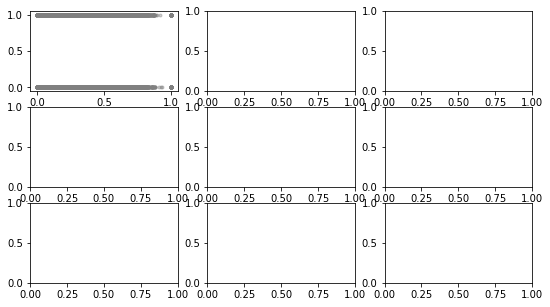

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
from matplotlib import ticker

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = data_final_12.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('target')

for i, column in enumerate(columnas_numeric):
    sns.regplot(
        x           = data_final_12[column],
        y           = data_final_12['target'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"precio vs {column}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

In [ ]:
columnas = ['Fecha_hora', 'user_followers', 'text', 'volume', 'target']
columnas

['Fecha_hora', 'user_followers', 'text', 'volume', 'target']

In [ ]:
#data.to_csv(root_path+'Data/data_clean.csv')

In [ ]:
englishStemmer=SnowballStemmer("english")

stopwords_en = stopwords.words('english');

# si no hacemos esto y usamos directo stopwords_sp, CountVectorizer devuelve un warning
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

vectorizer = CountVectorizer(stop_words = stopwords_en_stem, lowercase = True, strip_accents = 'unicode');

In [ ]:
#clean_words = [x for x in stemmer if x not in stopwords]

In [ ]:
palabras = []
for i in range(0,largo,50000):
    data = pd.read_csv(root_path+'Data/data_12h_prep.csv', header = 0, skiprows=i, nrows=20000)
    data.columns = columnas
    #tokenizacion = [word_tokenize(x) for x in data.text]
    stemmer = [englishStemmer.stem(x) for x in data.text]
    vectorizer.fit(stemmer);
    countvectorizer_encoding = vectorizer.transform(stemmer);
    data_text = pd.DataFrame(countvectorizer_encoding.todense(), 
             columns = vectorizer.get_feature_names())
    cantidad_apariciones = data_text.sum()
    mask = cantidad_apariciones < 3
    palabras.extend(cantidad_apariciones[mask].index)
    del data, countvectorizer_encoding, data_text, cantidad_apariciones, mask
    print(f'{i} of {largo}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


50000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


100000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


150000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


200000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


250000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


300000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


350000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


400000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


450000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


500000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


550000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


600000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


650000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


700000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


750000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


800000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


850000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


900000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


950000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1000000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1050000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1100000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1150000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1200000 of 1290445


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1250000 of 1290445


In [ ]:
palabras_a_sacar = ['btc', 'bitcoin', 'crypto', 'price', 'amp', 'get', 'market', 'time', 'one', 'see', 'us', 'eth', 'project', 'new', 'usd']
stopwords_en.extend(palabras_a_sacar)

In [ ]:
stopwords_en.extend(palabras)
stopwords_en

stopwords_en.extend(palabras_a_sacar)
stopwords_en

with open(root_path+'Data/stopwords_custom.txt', 'w') as f:
  for word in stopwords_en: 
    f.write(word+'\n')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# 5 - Pipeline  Desicion Tree (PRUEBA)
pasos = [('scaler', StandardScaler()), ('dt', tree.DecisionTreeClassifier(random_state=40))]
pipe_grid = Pipeline(pasos)
param_grid = {'dt__max_depth':[4,8,12]}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=pipe_grid, cv=tscv,
                        param_grid=param_grid)
gsearch.fit(X_train, y_train)


In [ ]:
2+1+2

5

In [ ]:
prediction = gsearch.predict(X_test)

performance = mean_squared_error(y_test, prediction)

performance


In [ ]:
cv = KFold(n_splits=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )


In [ ]:
#stemmer = [englishStemmer.stem(x) for x in data_clean_2.text]

In [ ]:
#clean_words = [x for x in stemmer if x not in stopwords_en]

In [ ]:
stopwords_en

In [ ]:
data_clean_2.text = clean_words
data_clean_2

In [ ]:
##########################################################

In [ ]:
tokenizacion = [word_tokenize(x) for x in data.text]
tokenizacion

In [ ]:
englishStemmer=SnowballStemmer("english")

In [ ]:
stopwords_en = stopwords.words('english');

# si no hacemos esto y usamos directo stopwords_sp, CountVectorizer devuelve un warning
stopwords_en_stem = [englishStemmer.stem(x) for x in stopwords_en]

vectorizer = CountVectorizer(stop_words = stopwords_en_stem, lowercase = True, strip_accents = 'unicode');

vectorizer.fit(data.text);
print('Vocabulario:\n',vectorizer.vocabulary_) # vocabulario del corpus con la frecuencia de cada término

In [ ]:
countvectorizer_encoding = vectorizer.transform(data.text);
print('\n Transformamos los textos a una matriz esparsa:',type(countvectorizer_encoding))

data_text = pd.DataFrame(countvectorizer_encoding.todense(), 
             columns = vectorizer.get_feature_names())


In [ ]:
cantidad_apariciones = data_text.sum()

In [ ]:
mask = cantidad_apariciones < 3
mask.sum()

In [ ]:
cantidad_apariciones[mask].index

In [ ]:
data_clean = data_text.drop(cantidad_apariciones[mask].index, axis=1)
data_clean

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

Tfidf_encoding=TfidfTransformer().fit_transform(data_clean);

pd.DataFrame(Tfidf_encoding.todense(),columns=data_clean.columns)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2);
P = svd.fit_transform(Tfidf_encoding)

#grafico
color = ['m', 'g', 'r', 'c', 'b','k']
plt.figure()
patches = []

for i,texto in enumerate(data.text):
    plt.plot(P[i,0], P[i,1], color[i]+"o")
    patches.append(mpatches.Patch(color=color[i], label='t'+str(i)))

plt.legend(handles=patches)
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
#plt.axis([-4, 4, -4, 4])
plt.show()

In [ ]:
# coeficientes (pesos) de los términos en cada una de las dos dimensiones
comp1,comp2 = svd.components_ 

# los ordenamos de menor a mayor y nos quedamos con los índices de sus posiciones en el array
indices=np.argsort(comp1); 

# invertimos para que queden ordenados de mayor a menor
indices=indices[::-1] 

# Evaluamos los términos en estas posiciones
print('Dimension 1:')
print(np.array(data_clean.columns)[indices]) 

print('\n')

indices=np.argsort(comp2);
indices=indices[::-1]
print('Dimension 2:')
print(np.array(data_clean.columns)[indices])



In [ ]:
data_clean['date_clean'] = data['Unnamed: 0'].values
data_clean['user_followers'] = data['user_followers'].values
data_clean['volume_clean'] = data['volume'].values
data_clean['target_clean'] = data['target'].values
data_clean.head(3)

In [ ]:
data['user_followers'].values

In [ ]:
data_clean['date_clean']

In [ ]:
data_clean['target_clean'].value_counts()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test=train_test_split(data_clean.drop(['target_clean', 'date_clean'], axis=1), data_clean['target_clean'],
                            stratify=data_clean['target_clean'],random_state=3);

nbc=MultinomialNB();

nbc.fit(X_train,y_train);
y_pred=nbc.predict(X_test);

print('Accuracy:',accuracy_score(y_test,y_pred))